One-dimensional Poisson model for the geomagnetic dipole moment
=====
***

The dipole field is generated by a series of delta function events. The recurrence time for the source events is governed by a Poisson process. The average recurrence time is fixed but the amplitude of the event is allowed to vary with a uniform distribution $U(a,b)$.  Negative (destructive) events are permitted by adopting a negative lower limit (a<0). The generation of the dipole field depends on the amplitude $A$ and the strength of the dipole field $x$.  In addition, a white noise source is added to the equations for $x$ to allow the field to reverse. We also need an additional white noise source to adjust the duration of transition fields. The imposed noise source has a zero mean and a variance $q_p$.

In [1]:
using Plots
using Distributions
using StatsBase
using DelimitedFiles
using DataFrames
using StatsPlots
using Printf

The event times are drawn from an expoential distribution with an average recurrence time

mean recurrence time = 0.003007069746976997 Myr


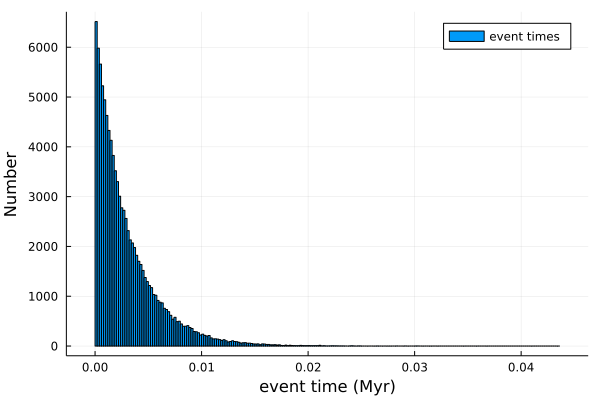

In [2]:
# evaluate event times
myr = 1.0e6;
recurrence = 3000/myr;         # average recurrence time (Myr)
nevents = 100000;
tevent = rand(Exponential(recurrence),nevents);  # Poisson event times
source = zeros(nevents);

# show distribution of event times
println("mean recurrence time = ",mean(tevent)," Myr")
histogram(tevent,label="event times",xlabel="event time (Myr)",ylabel="Number")

Model parameters. We adjust the values of $a$ and $b$ in the uniform distribution $U(a,b)$ to produce desired mean and variance of x(t))

In [3]:
# amplitude fluctuations
A = 5

amp_p = rand(Uniform(-0.4*A,5.9*A),nevents) # draw amplitude fluctuations from U(a,b)

# include random (white) noise
np = rand(Normal(),2*nevents);
qp = 180;       #  poloidal noise variance

# quenching magnitude
x0 = 4.7;         # defines onset of quenching; we chose a value slightly below the average <x>

We integrate the governing equations for the dipole field in two steps. The event interval is divided in half. Over the first half we have dipole decay and a white noise source. Over the second half we have dipole decay, white noise and a Poisson source event. The goal is to provide intermediate solutions for $x(t)$ between the source events. This helps when we interpolate the solution onto a uniform time spacing.

In [72]:
##Results
dfSummary = DataFrame(a=Float16[], b=Float16[], meanX=Float16[], stdX=Float16[], skewX=Float16[])

dfData = DataFrame()


# include random (white) noise
np = rand(Normal(),2*nevents);
qp = 180;       #  poloidal noise variance


runNumber=0
as = collect(-5:1:5)
for a in as
    bs = collect(a+1:1:5)
    for b in bs
#for A in collect(0.1:0.1:1)
       # a=-0.4*A
        #b=5.9*A
        runNumber+=1
        amp_p = rand(Uniform(a,b),nevents) # draw amplitude fluctuations from U(a,b)
        
        # quenching magnitude
        x0 = 0.9*(a+b)/2;         # defines onset of quenching; we chose a value slightly below the average <x>
        println(x0)
        
        # allocate memory for solution
        x = zeros(2*nevents);
        t = zeros(2*nevents);

        # set decay rate for dipole (here gamma = 1/tau_d, where tau_d is dipole decay time)
        gamma = 0.1 * 1000;

        # initial condition
        t[1] = 0.0;
        x[1] = 5.0;
        j = 2;

        # integrate over the number of source events
        for i = j : nevents
            # relax half a time step 
            dt = tevent[i]/2.0; #tevent is Poisson distribution of times of dipole spikes
            t[j] = t[j-1] + dt;
            gp = exp(-x[j-1]^2/2.2^2);
            x[j] = x[j-1] * exp(-gamma * dt) + np[j]*sqrt(gp*qp*dt);;

            # relax rest of time step
            j += 1;
            t[j] = t[j-1] + dt;
            x[j] = x[j-1] * exp(-gamma * dt)

            # evaluate quenching
            fp = 1.0/ (1.0 + (x[j]/x0)^2);

            # add event and random noise
            gp = exp(-x[j]^2/2.2^2)
            x[j] += amp_p[i] * x[j] * fp + np[j]*sqrt(gp*qp*dt); 
            source[i] = amp_p[i] * x[j] * fp + np[j]*sqrt(gp*qp*dt);
            
            #if j==3
                #println( "x[j] += amp_p[i] * x[j] * fp + np[j]*sqrt(gp*qp*dt)");
                #@printf( "%.2f += %.2f * %.2f] * %.2f + %.2f*sqrt(%.2f*%.2f*%.2f)",x[j],amp_p[i],x[j],fp,np[j],gp,qp,dt);
            #end
            j+= 1;
            

        end

        # fill last entry
        t[end] = t[end-1] + tevent[end]/2.0
        x[end] = x[end-1]
        println("mean x = ",mean(abs.(x))," std x = ",std(abs.(x))," skewness = ",skewness(abs.(x)))

        meanX = mean(abs.(x))
        stdX = std(abs.(x))
        skewX = skewness(abs.(x))
        push!(dfSummary, (a,b,meanX, stdX, skewX))
        colName="t$runNumber"
        dfData[!,colName] = t
        colName="x$runNumber"
        dfData[!,colName] = x
        
    end
end

println(dfSummary)

-4.05
mean x = 4.461806950088299 std x = 1.1775275683700608 skewness = -0.5121504474673778
-3.6
mean x = 3.234596621303662 std x = 1.2958017446391585 skewness = -0.16479273476082312
-3.15
mean x = 2.0418506367373777 std x = 1.2577416057879616 skewness = 0.41730095707816534
-2.7
mean x = 1.308557721424781 std x = 1.0458662070389178 skewness = 0.8735170284820148
-2.25
mean x = 1.0440918185704813 std x = 0.8508734535144822 skewness = 0.9872370775025021
-1.8
mean x = 0.9628974440636432 std x = 0.7433223407390659 skewness = 0.8732297543014584
-1.35
mean x = 0.9417425452476148 std x = 0.7210090470825297 skewness = 0.9301142251946799
-0.9
mean x = 0.9399589176663152 std x = 0.7256878494034537 skewness = 0.9275355985975153
-0.45
mean x = 0.8837579099577566 std x = 0.6314398582852486 skewness = 0.7003013308565655
0.0
mean x = 0.8116752297105546 std x = 0.5758624308493384 skewness = 0.7638840375024256
-3.15
mean x = 2.448422887459821 std x = 0.7610321065439087 skewness = -0.5761994549601522
-2.7

In [60]:
dfSummary

,a,b,meanX,stdX,skewX
,Float16,Float16,Float16,Float16,Float16
1,-5.0,-4.0,4.457,1.1875,-0.519
2,-5.0,-3.0,3.244,1.283,-0.1652


In [61]:
dfData



,t1,x1,t2,x2
,Float64,Float64,Float64,Float64
1,0.0,5.0,0.0,5.0
2,0.00320894,3.60727,0.00320894,3.60727
3,0.00641788,-6.2197,0.00641788,-4.00245
4,0.0129679,-3.22055,0.0129679,-1.97271
5,0.0195179,3.68576,0.0195179,1.43519
6,0.0195182,3.68485,0.0195182,1.43254
7,0.0195185,-5.87157,0.0195185,-2.86863
8,0.0207206,-5.19204,0.0207206,-2.32604
9,0.0219228,4.32511,0.0219228,5.36161


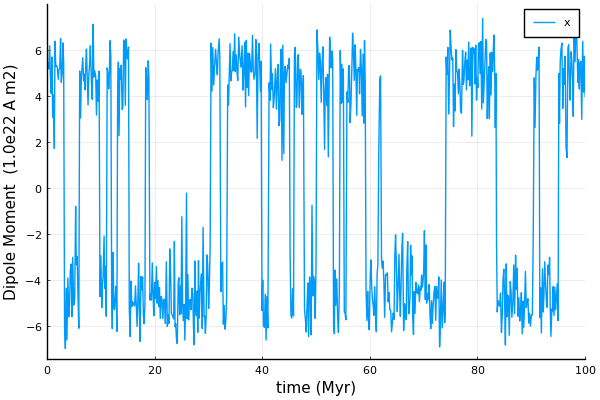

In [68]:
idecimate = 100;
@df dfData plot(:t1[1:idecimate:end], :x1[1:idecimate:end], label="x",xlabel="time (Myr)", ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

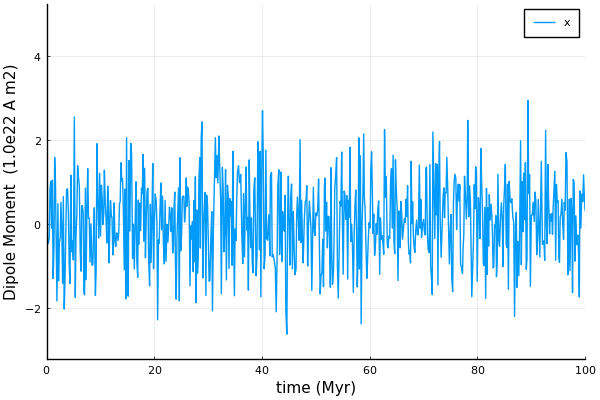

In [41]:
@df dfData plot(:t2[1:idecimate:end], :x2[1:idecimate:end], label="x",xlabel="time (Myr)", ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

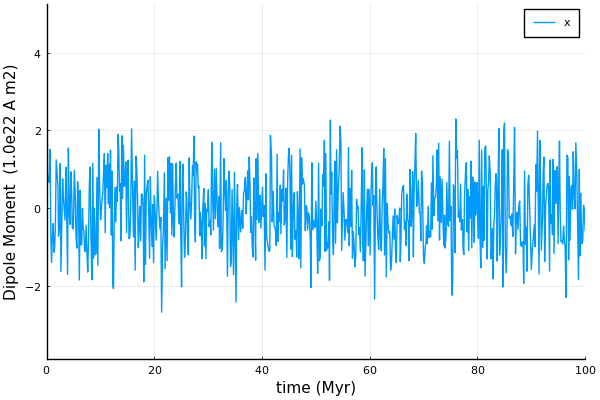

In [24]:
@df dfData plot(:t3[1:idecimate:end], :x3[1:idecimate:end], label="x",xlabel="time (Myr)", ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

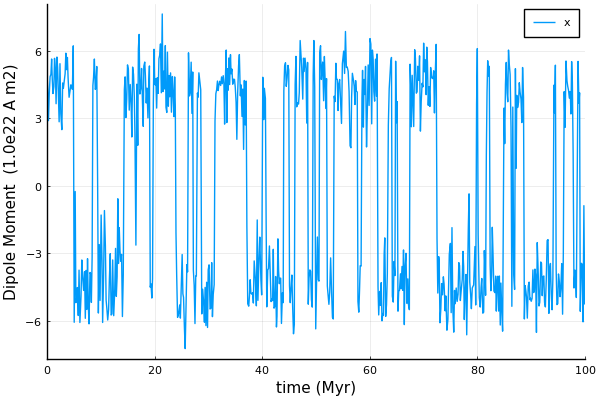

In [73]:
@df dfData plot(:t4[1:idecimate:end], :x4[1:idecimate:end], label="x",xlabel="time (Myr)", ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

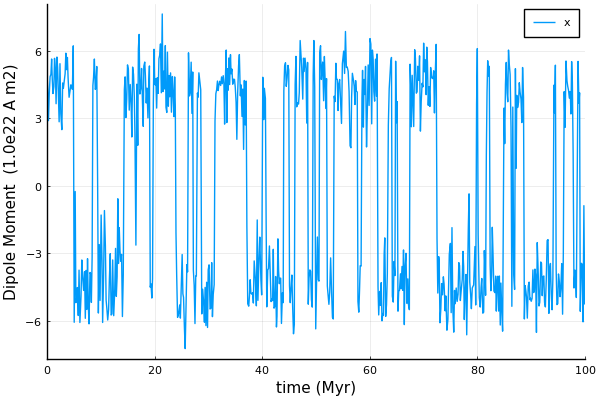

In [75]:
@df dfData plot(:t4[1:idecimate:end], :x4[1:idecimate:end], label="x",xlabel="time (Myr)", ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

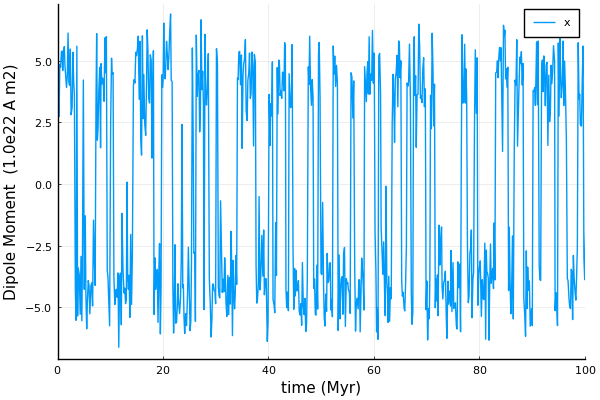

In [76]:
@df dfData plot(:t5[1:idecimate:end], :x5[1:idecimate:end], label="x",xlabel="time (Myr)", ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

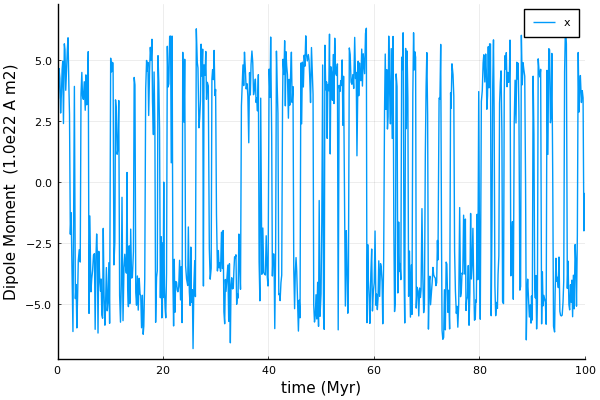

In [77]:
@df dfData plot(:t6[1:idecimate:end], :x6[1:idecimate:end], label="x",xlabel="time (Myr)", ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

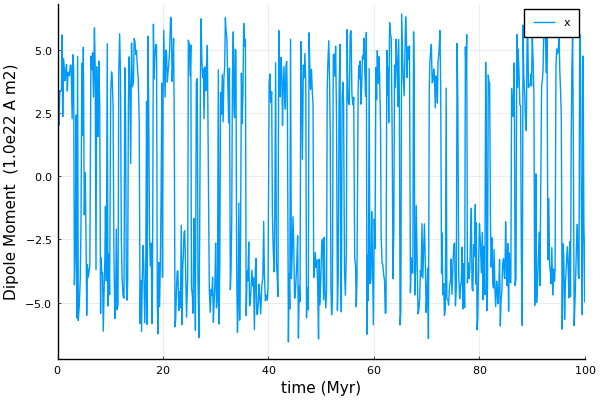

In [78]:
@df dfData plot(:t7[1:idecimate:end], :x7[1:idecimate:end], label="x",xlabel="time (Myr)", ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

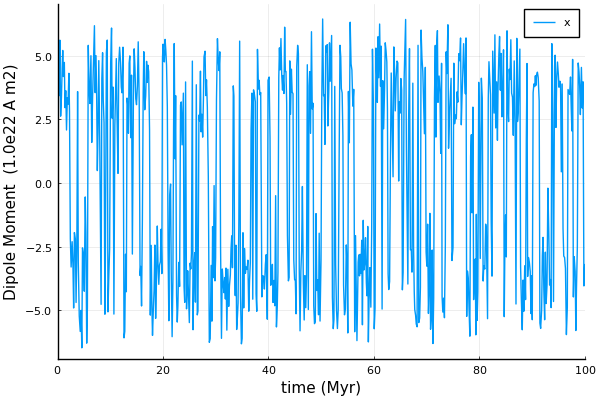

In [79]:
@df dfData plot(:t8[1:idecimate:end], :x8[1:idecimate:end], label="x",xlabel="time (Myr)", ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

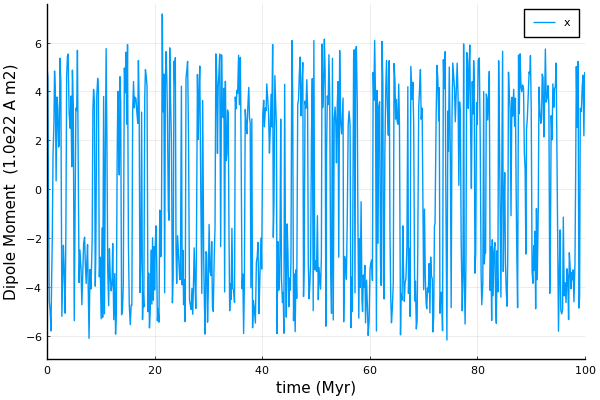

In [80]:
@df dfData plot(:t9[1:idecimate:end], :x9[1:idecimate:end], label="x",xlabel="time (Myr)", ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

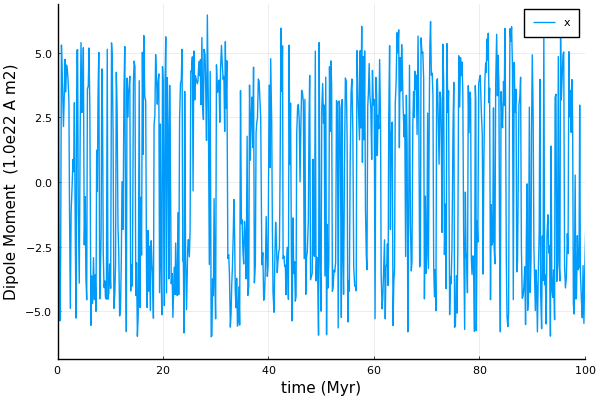

In [81]:
@df dfData plot(:t10[1:idecimate:end], :x10[1:idecimate:end], label="x",xlabel="time (Myr)", ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

In [21]:
# print time series 
idecimate = 100;
plot(t[1:idecimate:end],(x[1:idecimate:end]),
    label="x",xlabel="time (Myr)",
    ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

LoadError: UndefVarError: t not defined

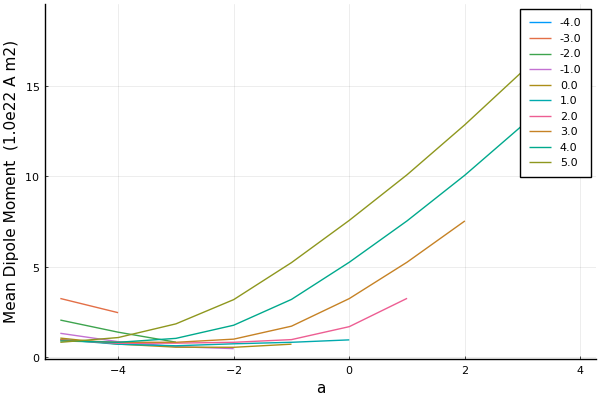

In [73]:
#plot relationships
pyplot()
@df dfSummary plot(:a, :meanX, group=:b, xlabel="a", ylabel="Mean Dipole Moment  (1.0e22 A m2)")

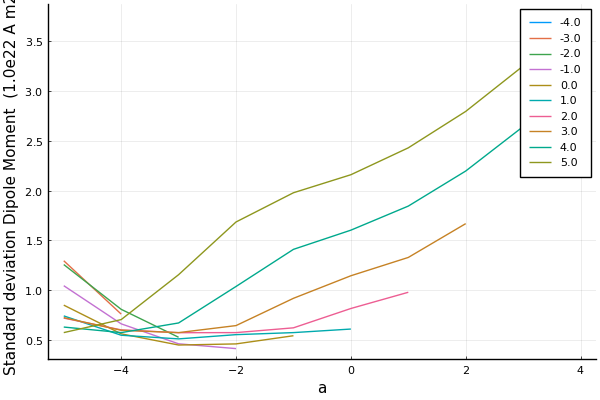

In [74]:
@df dfSummary plot(:a, :stdX, group=:b, xlabel="a", ylabel="Standard deviation Dipole Moment  (1.0e22 A m2)")


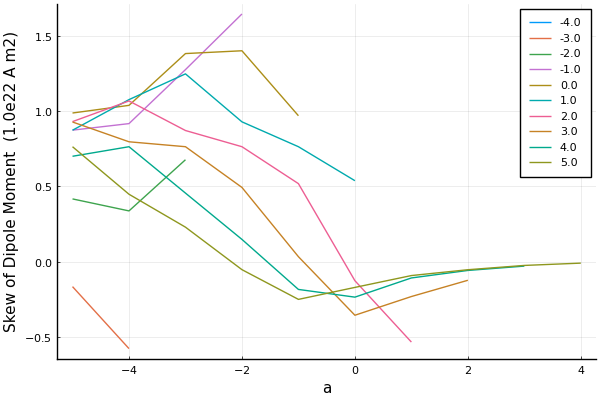

In [75]:
@df dfSummary plot(:a, :skewX, group=:b, xlabel="a", ylabel="Skew of Dipole Moment  (1.0e22 A m2)")

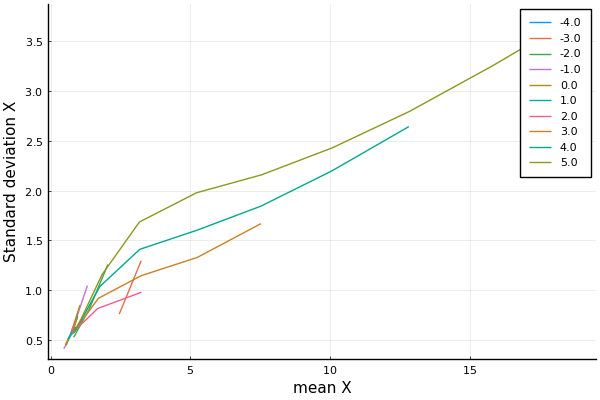

In [76]:
@df dfSummary plot(:meanX, :stdX, group=:b, xlabel="mean X", ylabel="Standard deviation X")

In [22]:
# print time series 
idecimate = 100;
plot(t[1:idecimate:end],(x[1:idecimate:end]),
    label="x",xlabel="time (Myr)",
    ylabel="Dipole Moment  (1.0e22 A m2)",
    xlim=(0,100))

LoadError: UndefVarError: t not defined

In [84]:
savefig("TimeSeries_Poisson3000.pdf")

In [1]:
# save to file
save_file = true
      
if save_file
    open("dipole_3000.txt","w")  do io
        writedlm(io,[t x])
    end
end

LoadError: UndefVarError: t not defined

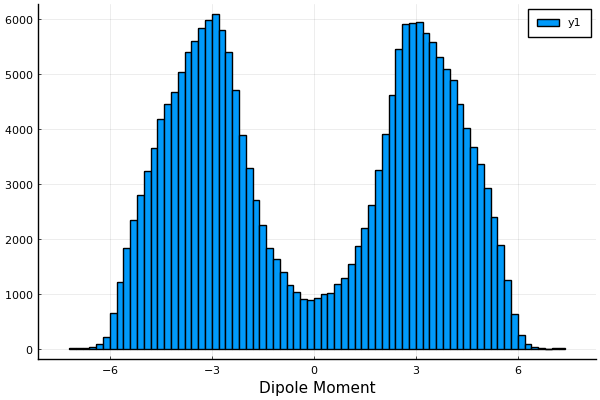

In [57]:
h = fit(Histogram,dfData.x2,nbins=100)
plot(h,xlabel="Dipole Moment")

Fold the dipole moment with negative values to postive values

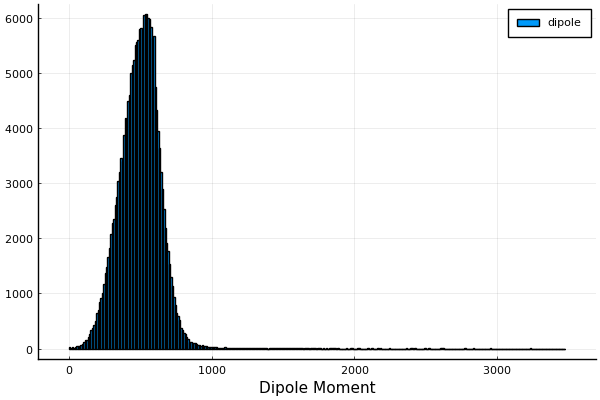

In [87]:
p1=histogram(abs.(x),xlabel="Dipole Moment",label="dipole")
plot(p1)

Evaluates the mean amplitudes $<A>$ and $<A^2>$, which appear in the definition of the drift $D_1$ and diffusion  $D_2$ terms.

In [10]:
function amplitudes(Ax,rate)
#
# evaluates the mean amplitudes <A>, <A2>, <A3.
# for poloidal and toroidal events
#
# input
# Ax, Ay - nominal amplitude of x and y events
# rate -  dimensionless rate of Poisson process

# output
# Ap, At  - mean amplitudes e.g. Ap[1,2,3]

# maximum and minimum amplitudes
Apmin = -0.4 * Ax;    # need to match the amplitude limits in U(a,b) from above
Apmax = 5.9 * Ax;



Ap = zeros(3);

Ap[1] = rate*(Apmin+Apmax)/2.0;
Ap[2] = rate*(Apmax^2 + Apmin^2 + Apmax*Apmin)/3.0;
Ap[3] = rate*(Apmax + Apmin)*(Apmax^2+Apmin^2)/4.0;



return Ap

end


amplitudes (generic function with 1 method)

507.437319046198


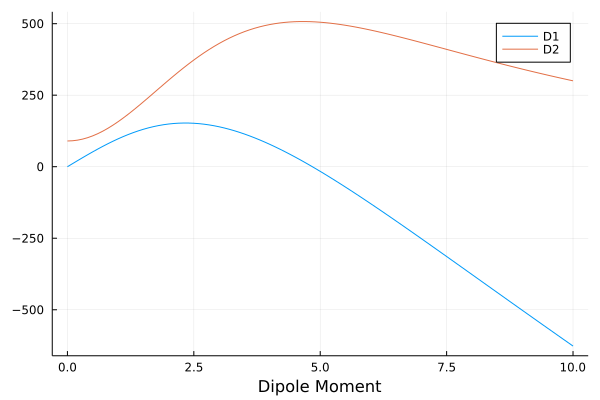

In [11]:
# compute drift and diffusion terms
rate = 1/recurrence
xbar = mean(abs.(x));
Ap = amplitudes(A,rate)


xplot = (0 : 0.1 : 10.0);
D1 = zeros(length(xplot))
D2 = zeros(length(xplot))
v = zeros(length(xplot))

for i = 1 : length(xplot)
    f = 1.0 / (1.0 + (xplot[i]/x0)^2);
    g = exp(-xplot[i]^2/2.2^2)
    D1[i] = -gamma*xplot[i] + Ap[1]*xplot[i]*f;
    D2[i] = 0.5*Ap[2]*(xplot[i]^2)*(f^2) + 0.5 * qp*g;
   # D3[i] = (1/6.0) * Ap[3]*(xplot[i]^2)*(f^3);
end

println(maximum(D2))
plot(xplot,D1,xlabel="Dipole Moment", label = "D1")
plot!(xplot,D2,label = "D2")


The histogram shows a noise source with $<dS> =0$, but it deviates significantly from $N(0,dt)$.

In [12]:
savefig("Drift&Diffusion.pdf")